# Latent Neural Process (LNP)

```{figure} ../images/computational_graph_LNPs.svg
---
width: 300em
name: computational_graph_LNPs
alt: Computational graph LNP
---
Computational graph for Latent Neural Processes.
```

In this notebook we will show how to train a LNP on samples from GPs and images using our framework, as well as how to make nice visualizations of sampled from LNPs.
We will follow {doc}`CNP notebook <CNP>` but plot samples from the posterior predictive instead of posterior predictive.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
import os
import warnings

import matplotlib.pyplot as pl
import torch

os.chdir("../..")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 8
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)

## Initialization

Let's load all the data. For more details about the data and some samples, see the {doc}`data <Datasets>` notebook.

In [2]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

# DATASETS
# gp
gp_datasets, gp_test_datasets, gp_valid_datasets = get_all_gp_datasets()
# image
img_datasets, img_test_datasets = get_img_datasets(["celeba32", "mnist", "zsmms"])

Now let's define the context target splitters, which given a data point will return the context set and target set by selecting randomly selecting some points and preprocessing them so that the features are in $[-1,1]$. 
We use the same as in {doc}`CNP notebook <CNP>`, namely all target points and uniformly sampling in $[0,50]$ and $[0,n\_pixels * 0.3]$ for 1D and 2D respectively.

In [3]:
from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs,
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
# 1d
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.0, b=50), targets_getter=get_all_indcs,
    )
)

# same as in 1D but with masks (2d) rather than indices
get_cntxt_trgt_2d = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0.0, b=0.3), target_masker=no_masker,
    )
)

# for ZSMMS you need the pixels to not be in [-1,1] but [-1.75,1.75] (i.e 56 / 32) because you are extrapolating
get_cntxt_trgt_2d_extrap = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0, b=0.3),
        target_masker=no_masker,
        upscale_factor=get_test_upscale_factor("zsmms"),
    )
)

Let's now define the models. We use the same architecture as in {doc}`CNP notebook <CNP>`. The only differences are that we: replace `CNP` with `LNP`, so the representation is a latent variable from which we sample using the reparametrization trick.

Note that we will be training using the conditional ELBO and thus set `is_q_zCct` to infer the latent variable using BOTH the context and target set (importance sampling). This also means that when evaluating we will evaluate the log likelihood using importance sampling.



In [4]:
from functools import partial

from npf import LNP
from npf.architectures import MLP, merge_flat_input
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    is_q_zCct=True,  # will use ELBO => importance sampling
    n_z_samples_train=1,
    n_z_samples_test=32,  # number of samples when eval
    XEncoder=partial(MLP, n_hidden_layers=1, hidden_size=R_DIM),
    Decoder=merge_flat_input(  # MLP takes single input but we give x and R so merge them
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), is_sum_merge=True,
    ),
    r_dim=R_DIM,
)

# 1D case
model_1d = partial(
    LNP,
    x_dim=1,
    y_dim=1,
    XYEncoder=merge_flat_input(  # MLP takes single input but we give x and y so merge them
        partial(MLP, n_hidden_layers=2, hidden_size=R_DIM * 2), is_sum_merge=True,
    ),
    **KWARGS,
)

# image (2D) case
model_2d = partial(
    LNP,
    x_dim=2,
    XYEncoder=merge_flat_input(  # MLP takes single input but we give x and y so merge them
        partial(MLP, n_hidden_layers=2, hidden_size=R_DIM * 3), is_sum_merge=True,
    ),
    **KWARGS,
)  # don't add y_dim yet because depends on data

n_params_1d = count_parameters(model_1d())
n_params_2d = count_parameters(model_2d(y_dim=3))
print(f"Number Parameters (1D): {n_params_1d:,d}")
print(f"Number Parameters (2D): {n_params_2d:,d}")

Number Parameters (1D): 301,634
Number Parameters (2D): 417,286


Note that there are more parameters than in `CNP notebook <CNP>` because need a MLP that maps the deterministic representation to a multivariate normal distribution from which we will sample $R \to Z$.

For more details about all the possible parameters, refer to the docstrings of `LNP` and the base class `LatentNeuralProcessFamily`.

In [5]:
# LNP Docstring

print(LNP.__doc__)


    (Latent) Neural process from [1].

    Parameters
    ----------
    x_dim : int
        Dimension of features.

    y_dim : int
        Dimension of y values.

    encoded_path : {"latent", "both"}
        Which path(s) to use:
        - `"latent"`  the decoder gets a sample latent representation as input as in [1].
        - `"both"` concatenates both the deterministic and sampled latents as input to the decoder [2].

    kwargs : 
        Additional arguments to `ConditionalNeuralProcess` and `NeuralProcessFamily`.

    References
    ----------
    [1] Garnelo, Marta, et al. "Neural processes." arXiv preprint
        arXiv:1807.01622 (2018).
    [2] Kim, Hyunjik, et al. "Attentive neural processes." arXiv preprint
        arXiv:1901.05761 (2019).
    


In [6]:
# NeuralProcessFamily Docstring
from npf import LatentNeuralProcessFamily

print(LatentNeuralProcessFamily.__doc__)

Base class for members of the latent neural process (sub-)family.
    
    Parameters
    ----------
    *args:
        Positional arguments to `NeuralProcessFamily`.

    encoded_path : {"latent", "both"}
        Which path(s) to use:
        - `"latent"` uses latent : the decoder gets a sample latent representation as input.
        - `"both"` concatenates both the deterministic and sampled latents as input to the decoder.

    is_q_zCct : bool, optional
        Whether to infer Z using q(Z|cntxt,trgt) instead of q(Z|cntxt). This requires the loss 
        to perform some type of importance sampling. Only used if `encoded_path in {"latent", "both"}`.

    n_z_samples_train : int or scipy.stats.rv_frozen, optional 
        Number of samples from the latent during training. Only used if `encoded_path in {"latent", "both"}`.
        Can also be a scipy random variable , which is useful if the number of samples has to be stochastic, for 
        example when using `SUMOLossNPF`.

    n_z

### Training

The main function for training is `train_models` which trains a dictionary of models on a dictionary of datasets and returns all the trained models.
See its docstring for possible parameters. The only difference with {doc}`CNP notebook <CNP>` is that we use the conditional ELBO loss `ELBOLossLNPF` to train the model despite the latent variables. 



Computational Notes :
- The following will either train all the models (`is_retrain=True`) or load the pretrained models (`is_retrain=False`)
- it will use a (single) GPU if available
- decrease the batch size if you don't have enough memory
- 30 epochs should give you descent results for the GP datasets (instead of 100)

In [7]:
import skorch
from npf import ELBOLossLNPF
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=ELBOLossLNPF,  # (approx) conditional ELBO Loss
    chckpnt_dirname="results/pretrained/",
    device=None,  # use GPU if available
    batch_size=32,
    lr=1e-3,
    decay_lr=10,  # decrease learning rate by 10 during training
    seed=123,
)


# 1D
trainers_1d = train_models(
    gp_datasets,
    {"LNP": model_1d},
    test_datasets=gp_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)


# 2D
trainers_2d = train_models(
    img_datasets,
    add_y_dim({"LNP": model_2d}, img_datasets),  # y_dim (channels) depend on data
    test_datasets=img_test_datasets,
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_2d,
    iterator_valid__collate_fn=get_cntxt_trgt_2d,
    datasets_kwargs=dict(
        zsmms=dict(iterator_valid__collate_fn=get_cntxt_trgt_2d_extrap,)
    ),  # for zsmm use extrapolation
    max_epochs=50,
    **KWARGS
)


--- Loading RBF_Kernel/LNP/run_0 ---

RBF_Kernel/LNP/run_0 | best epoch: None | train loss: 60.4488 | valid loss: None | test log likelihood: -37.1932

--- Loading Periodic_Kernel/LNP/run_0 ---

Periodic_Kernel/LNP/run_0 | best epoch: None | train loss: 125.5136 | valid loss: None | test log likelihood: -122.6891

--- Loading Noisy_Matern_Kernel/LNP/run_0 ---

Noisy_Matern_Kernel/LNP/run_0 | best epoch: None | train loss: 120.2593 | valid loss: None | test log likelihood: -105.8851

--- Loading Variable_Matern_Kernel/LNP/run_0 ---

Variable_Matern_Kernel/LNP/run_0 | best epoch: None | train loss: -78.7534 | valid loss: None | test log likelihood: -674.3751

--- Loading All_Kernels/LNP/run_0 ---

All_Kernels/LNP/run_0 | best epoch: None | train loss: 100.7922 | valid loss: None | test log likelihood: -76.0236

--- Loading celeba32/LNP/run_0 ---

celeba32/LNP/run_0 | best epoch: 50 | train loss: -3202.3485 | valid loss: -3365.3483 | test log likelihood: 3357.6426

--- Loading mnist/LNP/

### Plots

Let's visualize how well the model performs in different settings.

#### GPs Dataset

Let's define a plotting function that we will use in this section. We'll reuse the same function defined in {doc}`CNP notebook <CNP>`, but will use `n_samples = 20` to plot multiple posterior predictives conditioned on different latent samples.

In [8]:
from utils.ntbks_helpers import PRETTY_RENAMER, plot_multi_posterior_samples_1d
from utils.visualize import giffify


def multi_posterior_gp_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_1d,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[0, 2, 5, 7, 10, 15, 20, 30, 50, 100],
        fps=1.5,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        is_plot_generator=True,  # plot underlying GP
        is_plot_real=False,  # don't plot sampled / underlying function
        is_plot_std=True,  # plot the predictive std
        is_fill_generator_std=False,  # do not fill predictive of GP
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        # Fix formatting for coherent GIF
        plot_config_kwargs=dict(
            set_kwargs=dict(ylim=[-3, 3]), rc={"legend.loc": "upper right"}
        ),
        seed=seed,
        **kwargs,
    )

Let us visualize samples from the LNP when it is trained on samples from a single GP.

In [9]:
def filter_single_gp(d):
    """Select only data form single GP."""
    return {k: v for k, v in d.items() if ("All" not in k) and ("Variable" not in k)}


multi_posterior_gp_gif(
    "LNP_single_gp",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
    n_samples=20,  # 20 samples from the latent
)

```{figure} ../gifs/LNP_single_gp.gif
---
width: 35em
name: LNP_single_gp
alt: LNP on single GPs
---

Posterior predictive of LNPs conditioned on 20 different sampled latents (Blue line with shaded area for $\mu \pm \sigma | z$) and the oracle GP (Green line with dashes for $\mu \pm \sigma$) when conditioned on contexts points (Black) from an underlying function sampled from a GP. Each row corresponds to a different kernel and LNP trained on samples for the corresponding GP. 
```

From {numref}`LNP_single_gp` we see that LNPs are able to coherently sample functions from the marginal posterior predictive, by sampling different latent variable. It nevertheless suffer from the same underfitting issues as CNPs ({numref}`CNP_single_gp`).

In [16]:
###### ADDITIONAL 1D PLOTS ######

### RBF ###
def filter_rbf(d):
    """Select only data form RBF."""
    return {k: v for k, v in d.items() if ("RBF" in k)}


multi_posterior_gp_gif(
    "LNP_rbf",
    trainers=filter_rbf(trainers_1d),
    datasets=filter_rbf(gp_test_datasets),
    n_samples=20,
)

### Extrap ###
multi_posterior_gp_gif(
    "LNP_single_gp_extrap",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
    left_extrap=-2,  # shift signal 2 to the right for extrapolation
    right_extrap=2,  # shift signal 2 to the right for extrapolation
    n_samples=20,
)

### Varying hyperparam ###
def filter_hyp_gp(d):
    return {k: v for k, v in d.items() if ("Variable" in k)}


multi_posterior_gp_gif(
    "LNP_vary_gp",
    trainers=filter_hyp_gp(trainers_1d),
    datasets=filter_hyp_gp(gp_test_datasets),
    n_samples=20,
    model_labels=dict(main="Model", generator="Fitted GP")
)

### All kernels ###
# data with varying kernels simply merged single kernels
single_gp_datasets = filter_single_gp(gp_test_datasets)

# use same trainer for all, but have to change their name to be the same as datasets
base_trainer_name = "All_Kernels/LNP/run_0"
trainer = trainers_1d[base_trainer_name]
replicated_trainers = {}
for name in single_gp_datasets.keys():
    replicated_trainers[base_trainer_name.replace("All_Kernels", name)] = trainer

multi_posterior_gp_gif(
    "LNP_kernel_gp",
    trainers=replicated_trainers,
    datasets=single_gp_datasets,
    n_samples=20
)

#### Image Dataset

Let us now look at images. We again will use the same plotting function defined in {doc}`CNP notebook <CNP>` but with `n_samples = 3` to plot sampled functions from the posterior predictives. 

In [17]:
from utils.ntbks_helpers import plot_multi_posterior_samples_imgs
from utils.visualize import giffify


def multi_posterior_imgs_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_imgs,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[
            0,  
            0.005,
            0.01,
            0.02,
            0.05,
            0.1,
            0.15,
            0.2,
            0.3,
            0.5,
            "hhalf",  # horizontal half of the image
            "vhalf",  # vertival half of the image
        ],
        fps=1.5,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        n_plots=3,  # images per datasets
        is_plot_std=True,  # plot the predictive std
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        plot_config_kwargs={"font_scale":0.7},
        # Fix formatting for coherent GIF
        seed=seed,
        **kwargs,
    )

Let us visualize the CNP when it is trained on samples from different image datasets that do not involve extrapolation.

In [18]:
def filter_interpolation(d):
    """Filter out zsmms which requires extrapolation."""
    return {k: v for k, v in d.items() if "zsmms" not in k}


multi_posterior_imgs_gif(
    "LNP_img_interp",
    trainers=filter_interpolation(trainers_2d),
    datasets=filter_interpolation(img_test_datasets),
    n_samples=3,
)

```{figure} ../gifs/LNP_img_interp.gif
---
width: 30em
name: LNP_img_interp
alt: LNP on CelebA, MNIST
---

3 samples (means conditioned on different samples from the latent) of the posterior predictive of a LNP for CelebA $32\times32$ and MNIST for different context sets. The last row shows the standard deviation of the posterior predictive corresponding to the last sample.
```

From {numref}`LNP_img_interp` again shows underfitting but relatively coherent sampling.

Here are more samples, corresponding to specific percentiles of the test log loss.

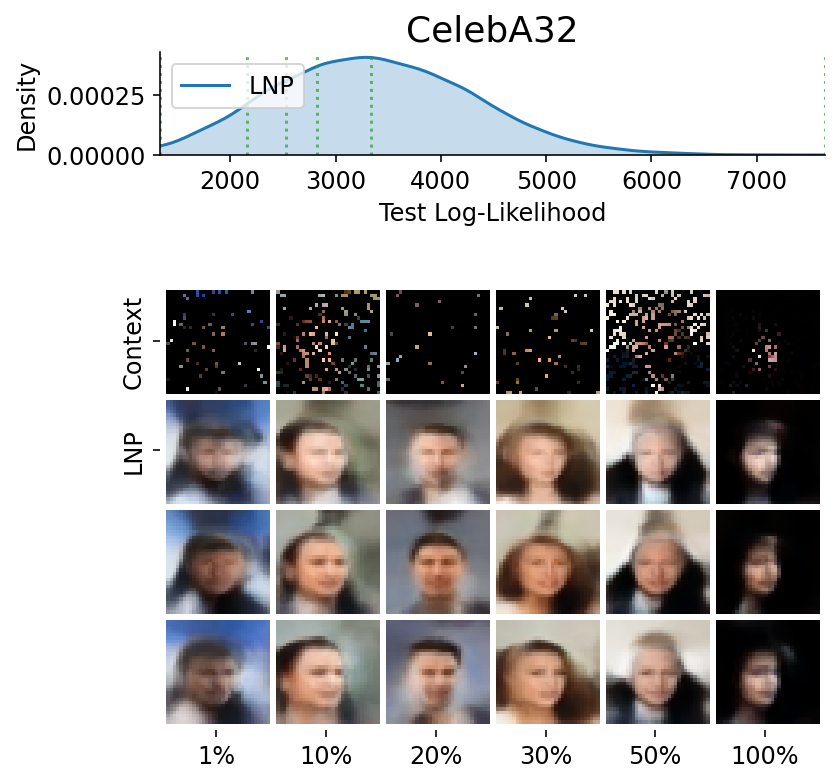

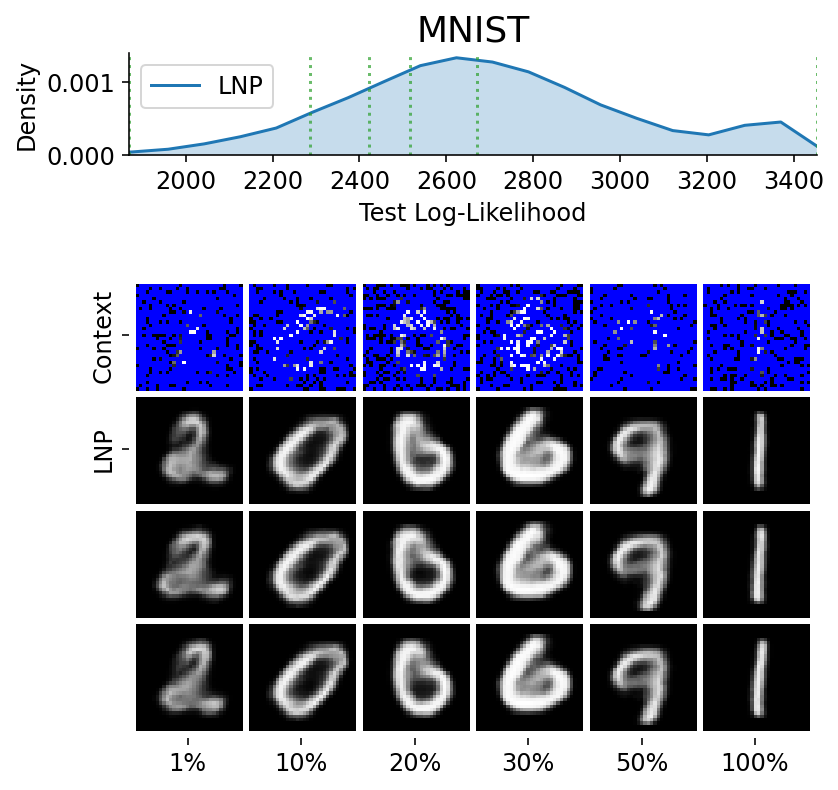

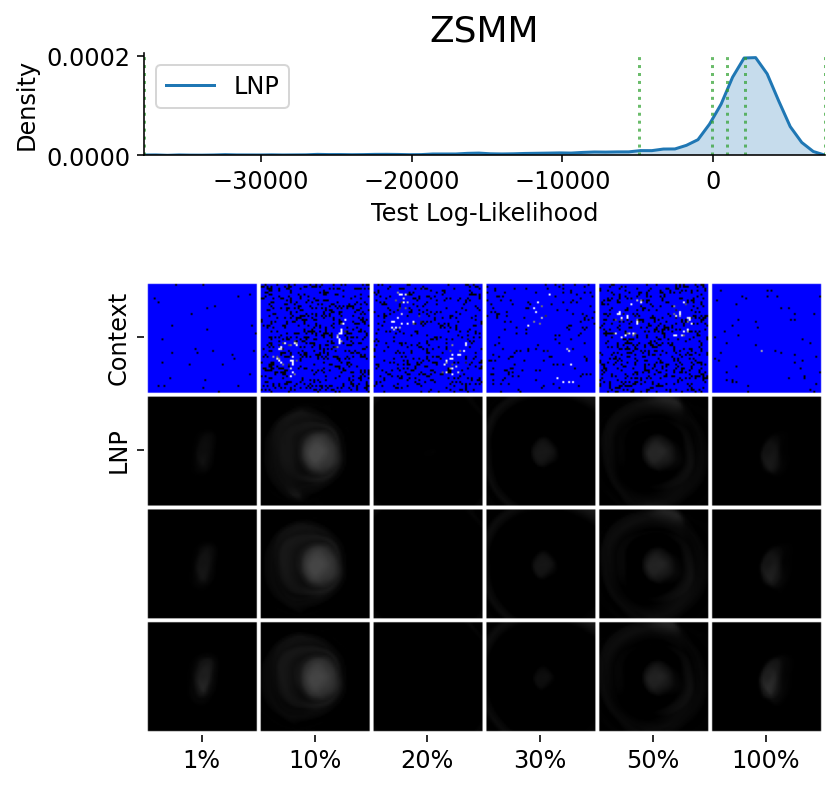

In [19]:
from utils.ntbks_helpers import PRETTY_RENAMER
from utils.visualize import plot_qualitative_with_kde

n_trainers = len(trainers_2d)
for i, (k, trainer) in enumerate(trainers_2d.items()):
    data_name = k.split("/")[0]
    model_name = k.split("/")[1]
    dataset = img_test_datasets[data_name]

    plot_qualitative_with_kde(
        [PRETTY_RENAMER[model_name], trainer],
        dataset,
        figsize=(6,6),
        percentiles=[1, 10, 20, 30, 50, 100],  # desired test percentile
        height_ratios=[1, 6],  # kde / image ratio
        is_smallest_xrange=True,  # rescale X axis based on percentile
        h_pad=0,  # padding
        title=PRETTY_RENAMER[data_name],
        upscale_factor=get_test_upscale_factor(data_name),
        n_samples=3,
    )

In [20]:
###### ADDITIONAL 2D PLOTS ######

### Gif all images ###
multi_posterior_imgs_gif(
    "LNP_img", trainers=trainers_2d, datasets=img_test_datasets, n_samples=3,
)